# Bayesian Machine Learning : Bayesian Linear Regression

In [6]:
# from jyquickhelper import add_notebook_menu
# add_notebook_menu()

In this notebook, we will study on Bayesian Inference methods, in particular, Bayesian Linear Regression.

### Student : IBRAHIM SOBH

## Diabetes dataset

We will work with the Diabetes dataset, which provides $n = 442$ diabetes patients.

The dataset contains ten baseline variables such as age, sex, **body mass index**, average blood pressure, and six blood serum measurements as well as the response of interest, a quantitative measure of disease progression one year after baseline.  It is therefore a regression task.

We provide below the dataset:

In [7]:
# EXECUTE THIS CELL
import numpy as np
import pandas as pd
from sklearn.datasets import load_diabetes
np.random.seed(27)

# Loading diabetes dataset directly from sklearn.datasets
X, y = load_diabetes(return_X_y=True, as_frame=True)
diabetes = pd.concat((X, y), axis=1)

# Shuffle the diabetes dataset
diabetes = diabetes.sample(frac=1)

# X, y separation (for simplicity sake we only study one feature)
X = diabetes["bmi"].to_numpy().reshape(-1, 1)
y = diabetes["target"].to_numpy()

# Split the data
n = 200
X_train = X[:-n]
X_test = X[-n:]

# Split the targets
y_train = y[:-n]
y_test = y[-n:]

## (Frequentist) linear regression with scikit-learn

We provide below the code for the linear regression with the package scikit-learn:

Intercept	: 	148.04218293324882
Coeffs	: 	[820.32338437]
RMSE	: 	63.042411357612636
R2	: 	0.3779859990889405


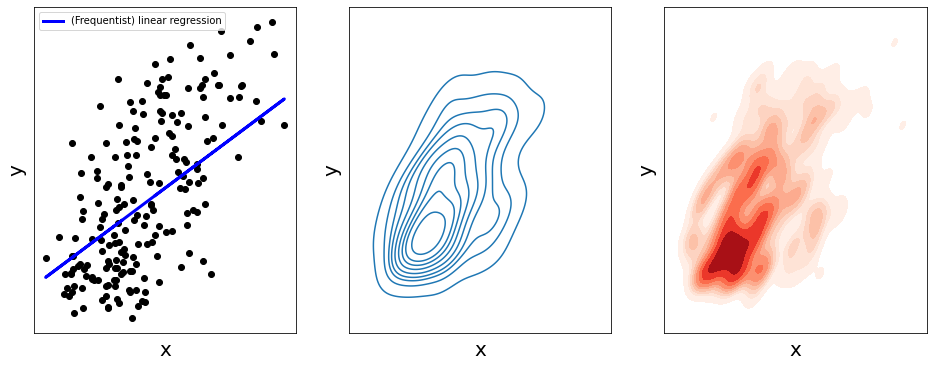

In [8]:
# EXECUTE THIS CELL
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns
import matplotlib.pyplot as plt

# create linear regression object
linreg = LinearRegression()

# train the model
linreg.fit(X_train, y_train)

# make predictions
y_pred = linreg.predict(X_test)

print(f"Intercept\t: \t{linreg.intercept_}")
print(f"Coeffs\t: \t{linreg.coef_}")
print(f"RMSE\t: \t{np.sqrt(mean_squared_error(y_test, y_pred))}")
print(f"R2\t: \t{r2_score(y_test, y_pred)}")

# plot outputs
plt.figure(figsize=(16, 6))

# plot1: basic scatter plot with linear regression
plt.subplot(1, 3, 1)
plt.scatter(X_test, y_test, color="black")
plt.plot(X_test, y_pred, color="blue", linewidth=3, label="(Frequentist) linear regression")
plt.xlabel("x", size=20)
plt.ylabel("y", size=20)
plt.legend()
plt.xticks(())
plt.yticks(())

# plot2: basic 2D density plot
plt.subplot(1, 3, 2)
sns.kdeplot(x=X_train.ravel(), y=y_train)
plt.xlabel("x", size=20)
plt.ylabel("y", size=20)
plt.xticks(())
plt.yticks(())

# plot3: customed 2D density plot
plt.subplot(1, 3, 3)
sns.kdeplot(x=X_train.ravel(), y=y_train, cmap="Reds", shade=True, bw_adjust=.5)
plt.xlabel("x", size=20)
plt.ylabel("y", size=20)
plt.xticks(())
plt.yticks(())
plt.show()

We will not provide a baseline but we will compare the Bayesian linear regression (BLR) with this frequentist one.

## Bayesian linear regression (from scratch)

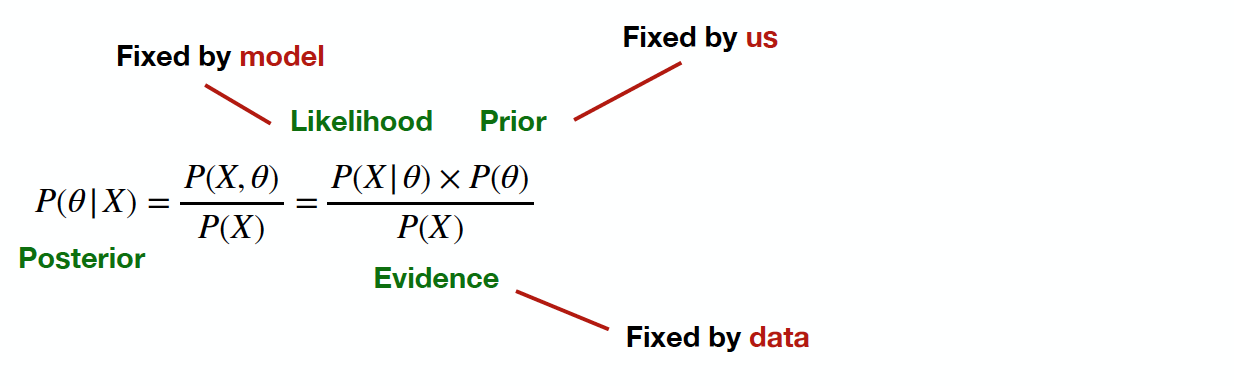

For a **supervised learning**, the definition of a posterior becomes:

$$
\mathbb{P}(\theta | x_i, y_i) = \dfrac{\mathbb{P}(y_i | \theta, x_i)\times \mathbb{P}(\theta|x_i)}{\mathbb{P}(y_i | x_i)} =_{\text{ reduced notation }}\dfrac{\mathbb{P}(y_i | \theta, x_i)\times \mathbb{P}(\theta)}{\mathbb{P}(y_i | x_i)}
$$

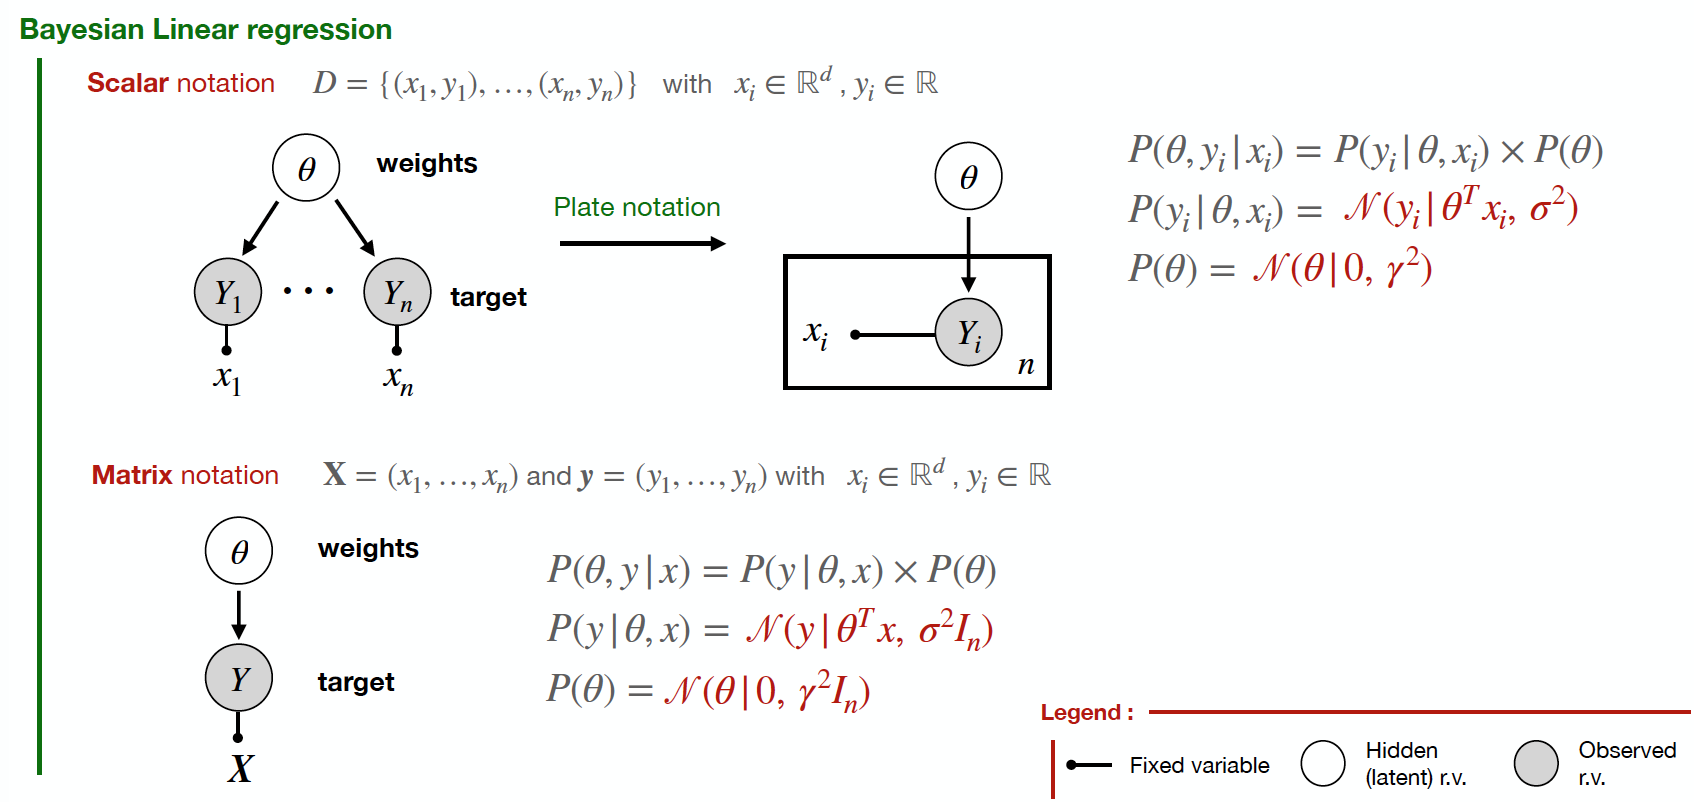

### Question 1: Likelihood function

For estimating parameters in a Bayesian statistics, we need to derive the likelihood function for the model that we want to fit. Define a function `log_likelihood(X, y, params, sdl)` which takes the training set (`X`, `y`), the  array of parameters `params`, the standard deviation `sdl` and returns the **log** likelihood of a BLR. 

**Remark:** We will take the intercept into account $\implies$ `params` is an array of size 2.

In [9]:
def log_likelihood(X, y, params, sdl):
    """
    Log likelihood function for the linear regression model.
    """
    return np.sum(np.log(sdl.pdf(X @ params))) - np.sum(y * (X @ params))

### Question 2: The prior

As always in Bayesian statistics, we have to specify a prior distribution for each parameter. Define a function `log_prior(X)` which returns the **log** prior of the set `X`.

In [2]:
from scipy.stats import multivariate_normal
import numpy as np

def logprior(X):
    """
    Log prior function for the linear regression model.
    """
    prior_mean = np.zeros(X.shape[1])
    prior_cov = np.eye(X.shape[1])
    return  multivariate_normal(prior_mean, prior_cov)

### Question 3: The posterior

We know that the posterior is $\mathbb{P}(\theta | x_i, y_i) = \boxed{\dfrac{\mathbb{P}(y_i | \theta, x_i)\times \mathbb{P}(\theta)}{\mathbb{P}(y_i | x_i)}}  \propto \mathbb{P}(y_i | \theta, x_i)\times \mathbb{P}(\theta)$.

Define `log_posterior_propto(X, y, params, sdl=1, sdp=1)` the logarithm of the right hand side quantity.

In [3]:
def log_posterior_propto(X, y, params, sdl=1, sdp=1):
    """
    Log posterior function for the linear regression model.
    """
    return log_likelihood(X, y, params, sdl) + logprior(X).logpdf(params)

The MCMC will work on this `log_posterior` and its normalization will be the approxiamtion of the posterior.

### Question 4: MCMC

We will implement the Metropolis-Hastings algorithm. One of the most frequent applications of this algorithm is sampling from the posterior density.

- Choose an **auxiliary distribution** to be sampled from.

- Define `metropolis` the Metropolis-Hastings algorithm.

In [12]:
def MCMC(X, y, params, sdl=1, sdp=1, n_iter=1000):
    """
    MCMC function for the linear regression model.
    """
    # Initialize the chain
    chain = np.zeros((n_iter, X.shape[1]))
    chain[0] = params
    # Loop over the chain
    for i in range(1, n_iter):
        # Draw a sample from the proposal distribution
        proposal = np.random.multivariate_normal(chain[i-1], sdp * np.eye(X.shape[1]))
        # Compute the acceptance probability
        log_acceptance_probability = log_posterior_propto(X, y, proposal, sdl, sdp) - log_posterior_propto(X, y, chain[i-1], sdl, sdp)
        # Accept or reject the proposal
        if np.log(np.random.uniform()) < log_acceptance_probability:
            chain[i] = proposal
        else:
            chain[i] = chain[i-1]
    return chain

### Question 5: Model fitting

- Fit your bayesian linear regression on the data `X_train` and `y_train`.


- Predict and evaluate the model's performance with MSE thanks to `X_test` and `y_test`.


- Plot the estimation alongside with its [credible interval](https://en.wikipedia.org/wiki/Credible_interval).

In [22]:
import numpy as np
class bayesian_linear_regression():
  def __init__(self,S0, M0): # M0 -> prior mean, S0 -> prior covariance matrix
    self.S0 = S0
    self.M0 = M0

  def fit(self,x,y, return_self = False):
    self.x = x
    self.y = y

    # Maximum likelihood estimation for sigma parameter
    theta_mle = np.linalg.pinv(x.T@x)@(x.T@y)
    sigma_2_mle = np.linalg.norm(y - x@theta_mle)**2
    sigma_mle = np.sqrt(sigma_2_mle)

    # Calculating predicted mean and covariance matrix for theta
    self.SN = np.linalg.pinv(np.linalg.pinv(self.S0) + (sigma_mle**-2)*x.T@x)
    self.MN = self.SN@(np.linalg.pinv(self.S0)@self.M0 + (sigma_mle**-2)*(x.T@y).squeeze())

    # Calculating predicted mean and covariance matrix for data
    self.pred_var = x@self.SN@x.T
    self.y_hat_map = x@self.MN
    if return_self:
      return (self.y_hat_map, self.pred_var)
    
  def predict(self, x):
    self.pred_var = x@self.SN@x.T
    self.y_hat_map = x@self.MN
    return (self.y_hat_map, self.pred_var)


In [23]:
S0 = np.eye(X_train.shape[1])
M0 = np.zeros((X_train.shape[1], ))
model = bayesian_linear_regression(S0, M0)
model.fit( X_train, y_train)
model.predict(X_test)

(array([ 8.26473758e-07,  2.57402873e-06, -3.35517563e-06,  3.44780621e-06,
        -2.35657279e-06, -2.73104886e-06, -2.35657279e-06, -1.73244602e-06,
         3.38539353e-06, -1.91968405e-06, -3.66723902e-06,  2.88609211e-06,
        -3.23035028e-06, -1.73244602e-06,  3.57263157e-06,  8.88886435e-07,
         9.51299113e-07,  1.76266392e-06,  1.39934306e-07,  3.44780621e-06,
         5.63224992e-06, -5.22755595e-06,  3.57263157e-06,  3.69745692e-06,
         7.75216288e-08,  6.06913866e-06,  1.76266392e-06, -4.21779791e-07,
        -1.35796995e-06, -5.46605146e-07, -3.41758831e-06,  2.02346984e-07,
        -1.48279531e-06,  8.26473758e-07,  2.32437802e-06,  4.94571047e-06,
         3.13574282e-06, -2.23174744e-06,  1.01371179e-06, -1.91968405e-06,
         2.38679069e-06,  2.69885408e-06, -3.35517563e-06, -1.29555727e-06,
        -1.72129081e-07,  5.76823048e-07,  1.01371179e-06, -2.34541758e-07,
        -8.58668533e-07, -3.66723902e-06,  5.44501189e-06, -5.46605146e-07,
        -1.7

## Bayesian linear regression (with external packages)

The most popular Bayesian Inference in Python is [PyMC3](https://docs.pymc.io/en/v3/) (Probabilistic Programming in Python) or [bambi](https://bambinos.github.io/bambi/main/index.html) (BAyesian Model-Building Interface) which is built on top of PyMC3. We will use bambi in this notebook. This package includes numerous utilities for constructing Bayesian Models and using for example MCMC methods to infer the model parameters. 

We will use [ArviZ]() (Exploratory analysis of Bayesian models) package which provides some tools for diagnostics and visualizations of Bayesian inference in Python.

### Dataset and packages

In [ ]:
import arviz as az
import bambi as bmb

In [18]:
# EXECUTE THIS CELL
import numpy as np
import pandas as pd
from sklearn.datasets import load_diabetes
np.random.seed(27)

# Loading diabetes dataset directly from sklearn.datasets
X, y = load_diabetes(return_X_y=True, as_frame=True)
diabetes = pd.concat((X, y), axis=1)

# Shuffle the diabetes dataset
diabetes = diabetes.sample(frac=1)

# X, y separation (for simplicity sake we only study one feature)
data = diabetes[["bmi", "target"]]

# Split the data
n = 200
data_train = data[:-n]
data_test = data[-n:]

### Model

With the bambi package, Bayesian linear regression requires:

1. the construction of a formula relating the features (e.g. named `X1`, `X2`, `X3`) to the target (e.g. named `target`) with the syntax :

```
"target ~ X1 + X2 + X3"
```
before

2. sampling from the posterior distribution (e.g. using MCMC).

In [ ]:
# Context for the model
model = bmb.Model('target ~ bmi', data_train, family='gaussian')

# Fit the model using 500 on each of 3 chains
results = model.fit(draws=500, chains=3, method="mcmc") # one can also use "vi" for variational inference

In [ ]:
model

Formula: target ~ bmi
Family name: Gaussian
Link: identity
Observations: 242
Priors:
  Common-level effects
    Intercept ~ Normal(mu: 145.8595, sigma: 185.0665)
    bmi ~ Normal(mu: 0.0, sigma: 3859.5213)

  Auxiliary parameters
    sigma ~ HalfStudentT(nu: 4, sigma: 73.9125)
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()

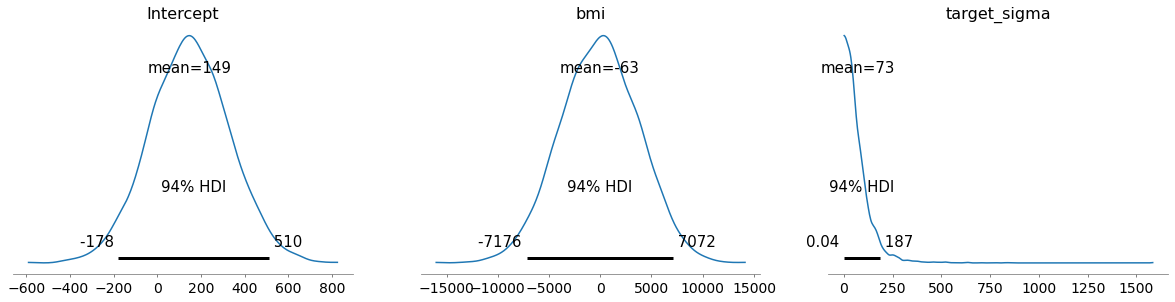

In [ ]:
# plot priors
model.plot_priors();

We observe that our model parameters are not point estimates but **distributions** (described by histograms). The mean of each distribution can be taken as the most likely estimate. The histograms provide the Highest Density Interval (HDI) of posterior distributions: all points within this interval have a higher probability density than points outside the interval. The HDI can be used in the context of uncertainty characterisation of posterior distributions as Credible Interval (CI). A credible interval is the Bayesian equivalent of a confidence interval in Frequentist statistics (although with different interpretations).

### Results

Let us study the posteriors.

**Remarks:** about left and right plots

- **Left:** posterior density plots contains three overlaid distributions because we ran three MCMC chains. 

- **Right:** trace plots showing the sampling paths of the three MCMC chains.

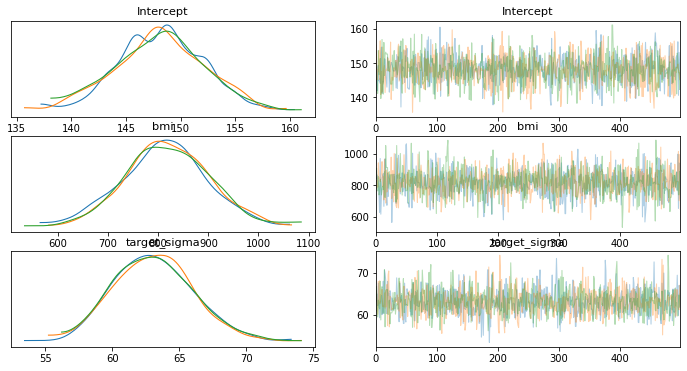

In [ ]:
# plot the posteriors
az.plot_trace(results, compact=False);

Alternative way

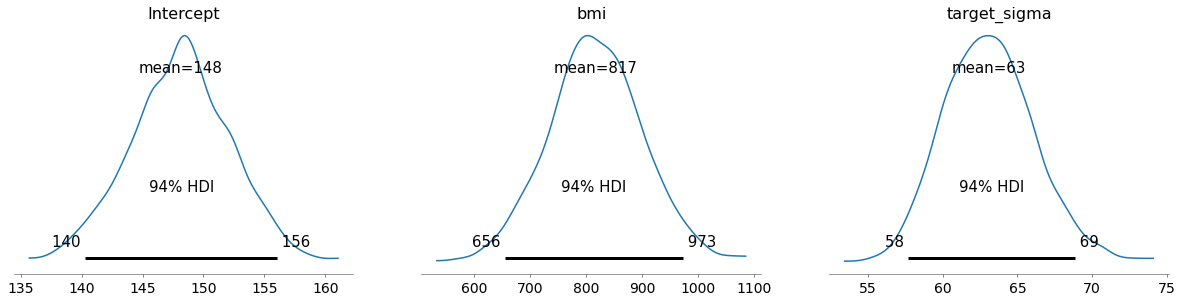

In [ ]:
# plot the posteriors: alternative
az.plot_posterior(results);

A summary of the results is:

In [ ]:
# key summary and diagnostic info on the model parameters
az.summary(results)

mean      sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
Intercept     148.110   4.150  140.311  156.025      0.093    0.066    1970.0   
bmi           817.117  84.455  655.934  972.532      1.947    1.379    1890.0   
target_sigma   63.098   3.035   57.705   68.875      0.070    0.050    1909.0   

              ess_tail  r_hat  
Intercept       1170.0    1.0  
bmi             1113.0    1.0  
target_sigma    1007.0    1.0

### Uncertainty in predictions

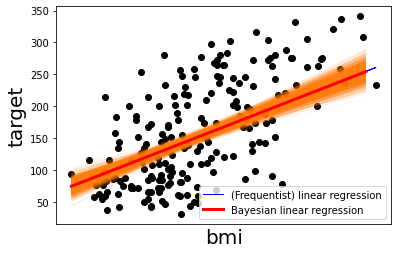

In [ ]:
import matplotlib.pyplot as plt

intercept = results.posterior["Intercept"].stack(draws=("chain", "draw"))
slope = results.posterior["bmi"].stack(draws=("chain", "draw"))
a = intercept.values
b = slope.values

x = np.arange(data_test["bmi"].min(), data_test["bmi"].max(), 0.02)
plt.plot(x, a + b * x.reshape(-1, 1), color="C1", lw=0.1, alpha=0.6)
plt.plot(X_test, y_pred, color="blue", linewidth=1, label="(Frequentist) linear regression")
plt.plot(x, a.mean() + b.mean() * x, color="red", linewidth=3, label="Bayesian linear regression")
plt.scatter(data_test["bmi"], data_test["target"], color="black")
plt.xlabel("bmi", size=20)
plt.ylabel("target", size=20)
plt.xticks(())
#plt.yticks(())
plt.legend()
plt.show()

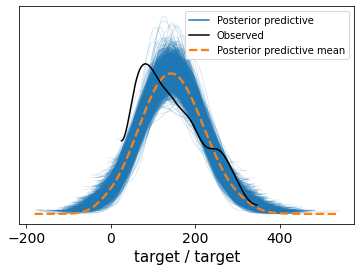

In [ ]:
# Once fitted, the model can be used to compute a posterior predictive distribution
posterior_predictive = model.predict(results, kind="pps")
az.plot_ppc(results)
plt.legend(loc="best");
# overall a good estimate, except when the target is < 50.

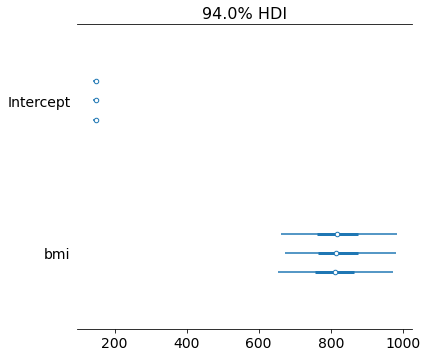

In [ ]:
az.plot_forest( results, var_names=["Intercept", "bmi"]);